In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from gym_agro_carbon.models.context import ContextSpec, ContextEncoder
from gym_agro_carbon.models.reward import RewardSpec, RewardModel
from gym_agro_carbon.envs.grid import EnvSpec, AgroCarbonGridEnv

In [3]:
H, W = 6, 8
T = 5

S = 8      # 8 soil types
M = 7      # maturity age (example)

alpha = 0.6
seed = 123

context_spec = ContextSpec(S=S, M=M)
context_encoder = ContextEncoder(context_spec)

reward_spec = RewardSpec(
    context_spec=context_spec,
    alpha=alpha,
    sigma_c=0.05,
    sigma_y=0.05,
    tree_carbon_gain=0.50,
    tree_yield_gain=0.10,
)
reward_model = RewardModel(spec=reward_spec, encoder=context_encoder)

env_spec = EnvSpec(
    H=H, W=W, T=T,
    alpha=alpha,
    S=S, M=M,
    seed=seed,
)

env = AgroCarbonGridEnv(
    env_spec=env_spec,
    context_spec=context_spec,
    reward_model=reward_model,
)

In [4]:
obs, info = env.reset()

print("obs shape:", obs.shape)
print("obs dtype:", obs.dtype)
print("obs min/max:", int(obs.min()), int(obs.max()))
print("num_contexts:", env_spec.num_contexts)
print("info:", info)

assert obs.shape == (H, W)
assert obs.min() >= 0
assert obs.max() < env_spec.num_contexts

obs shape: (6, 8)
obs dtype: int32
obs min/max: 0 56
num_contexts: 64
info: {'t': 0, 'alpha': 0.6, 'action_labels': {0: 'FALLOW', 1: 'FALLOW_MANURE', 2: 'TREE_PLANTING', 3: 'IDLE'}, 'num_agent_trees': 0}


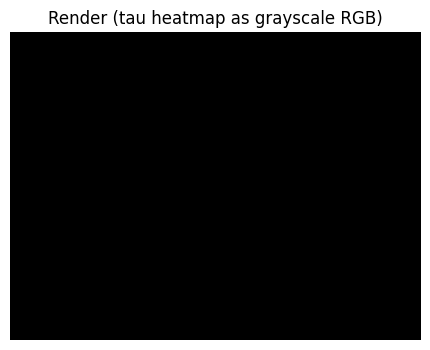

In [5]:
frame = env.render()  # rgb_array derived from tau
plt.figure(figsize=(6, 4))
plt.imshow(frame)
plt.axis("off")
plt.title("Render (tau heatmap as grayscale RGB)")
plt.show()

In [6]:
actions = np.random.randint(0, env_spec.num_actions, size=(H, W), dtype=np.int32)

obs2, R, terminated, truncated, info2 = env.step(actions)

print("R:", R)
print("terminated:", terminated, "truncated:", truncated)
print("obs2 shape:", obs2.shape)

print("reward_grid shape:", info2["reward_grid"].shape)
print("C_grid shape:", info2["C_grid"].shape)
print("Y_grid shape:", info2["Y_grid"].shape)
print("num_agent_trees:", info2["num_agent_trees"])

assert obs2.shape == (H, W)
assert info2["reward_grid"].shape == (H, W)
assert info2["C_grid"].shape == (H, W)
assert info2["Y_grid"].shape == (H, W)

R: 28.177047729492188
terminated: False truncated: False
obs2 shape: (6, 8)
reward_grid shape: (6, 8)
C_grid shape: (6, 8)
Y_grid shape: (6, 8)
num_agent_trees: 10


In [7]:
env.reset(seed=999)

# Step 1: plant trees everywhere
plant_actions = np.full((H, W), env_spec.ACTION_TREE_PLANTING, dtype=np.int32)
_, _, _, _, _ = env.step(plant_actions)

tau_after_plant = env.state.tau.copy()
print("tau min/max after plant:", int(tau_after_plant.min()), int(tau_after_plant.max()))
assert tau_after_plant.min() == 1  # every cell was empty -> becomes 1

# Step 2: do IDLE everywhere (trees should age)
idle_actions = np.full((H, W), env_spec.ACTION_IDLE, dtype=np.int32)
_, _, _, _, _ = env.step(idle_actions)

tau_after_age = env.state.tau.copy()
print("tau min/max after one aging step:", int(tau_after_age.min()), int(tau_after_age.max()))
assert tau_after_age.min() == 2

tau min/max after plant: 1 1
tau min/max after one aging step: 2 2


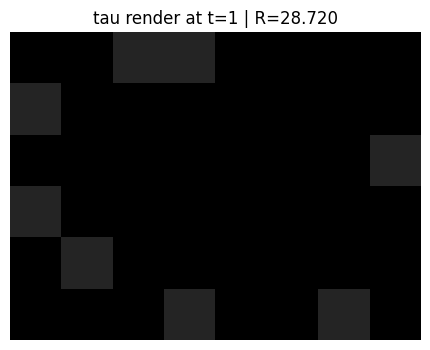

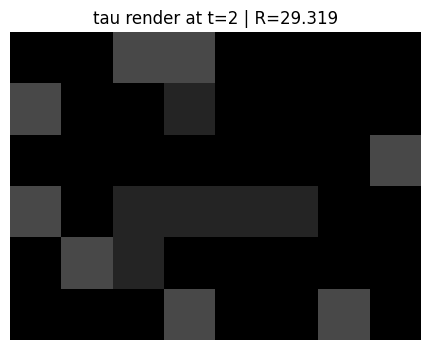

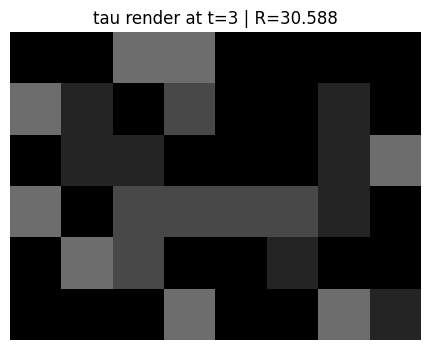

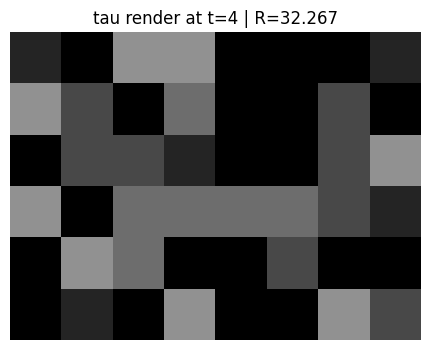

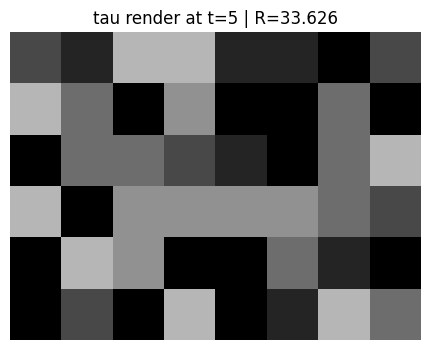

Episode finished.


In [8]:
env.reset(seed=42)

for t in range(T):
    actions = np.random.randint(0, env_spec.num_actions, size=(H, W), dtype=np.int32)
    obs, R, terminated, truncated, info = env.step(actions)

    frame = env.render()
    plt.figure(figsize=(6, 4))
    plt.imshow(frame)
    plt.axis("off")
    plt.title(f"tau render at t={info['t']} | R={R:.3f}")
    plt.show()

    if terminated:
        print("Episode finished.")
        break